In [1]:
# Colab was used for this notebook hence the library installs
%%capture
!pip install pycaret --quiet --upgrade
!pip install dabl --quiet --upgrade
!pip install shap --quiet --upgrade
!pip install sdv  --quiet --upgrade
!pip install sdv[ctgan] --quiet --upgrade
!pip install baytune --quiet --upgrade
!pip install optuna --quiet --upgrade

UsageError: Line magic function `%%capture` not found.


## **Why this was done**
1. Learn about synthetic data generation and see if it can improve a model
2. Work with PyCaret on a classification problem
3. Work on an insurance related problem (although ficticious data)
4. Build a `streamlit` app

## **The data**
The data is used in [here](https://www.kaggle.com/simranjain17/insurance) around how much charges for a single person will be. The features for each person are:

* ` age `
* ` bmi `
* ` children `
* ` sex `
* ` smoker `
* ` region `


# **Libraries**

In [1]:
from pycaret.classification import * 
#from pycaret.regression import * # Preprocessing, modelling, interpretation, deployment...
from sklearn.impute import SimpleImputer
import pandas as pd # Basic data manipulation
#import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN, GaussianCopula, CTGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
#from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
#from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps
import sdv.constraints as cons # Evaluate synthetic data

# **Importing data**

In [12]:
# Read and output the top 5 rows
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges
0,25,59,female,27.72,3,no,southeast,2
1,336,60,male,25.74,0,no,southeast,2
2,47,28,female,34.77,0,no,northwest,0
3,106,19,female,28.40,1,no,southwest,0
4,1269,45,male,27.50,3,no,southwest,1


We first transform the regression problem into a classification problem. We split the data with respect to four quantiles. Therefore, the number of for each label of charges is roughly the same..

In [3]:
ins_data = pd.read_csv("insurance.csv")
ins_data['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,3
1,18,male,33.770,1,no,southeast,0
2,28,male,33.000,3,no,southeast,0
3,33,male,22.705,0,no,northwest,3
4,32,male,28.880,0,no,northwest,0
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,2
1334,18,female,31.920,0,no,northeast,0
1335,18,female,36.850,0,no,southeast,0
1336,21,female,25.800,0,no,southwest,0


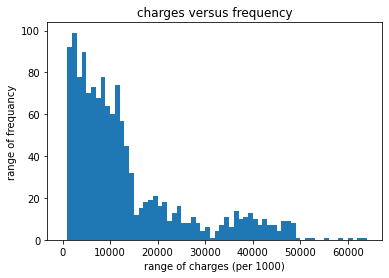

In [4]:
ins_data = pd.read_csv("insurance.csv")
from matplotlib import pyplot as plt
plt.title("charges versus frequency")
plt.xlabel("range of charges (per 1000)")
plt.ylabel("range of frequancy")
plt.hist(ins_data['charges'], bins=[1000*i for i in range (65)])
ins_data['charges'].describe()
def transform(x):
    if x<4700: return 0 # 25 percntile
    if x<9300: return 1 # median
    if x<16600: return 2 # 75 percentile
    return 3
ins_data["charges"]=ins_data["charges"].map(transform)
ins_data

(array([331., 334., 338., 335.]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

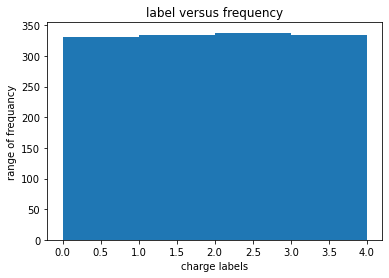

In [5]:
plt.title("label versus frequency")
plt.xlabel("charge labels")
plt.ylabel("range of frequancy")
plt.hist(ins_data["charges"],bins=[i for i in range(5)])

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [6]:
# Target feature
target = "charges"

# Continuous/numeric features
cont_feats = ["age", "bmi"]

# Ordinal features
ord_feats = {"children" : ["0", "1", "2", "3", "4", "5"]}

# Categorical geatures
cat_feats = ["region", "smoker", "sex"]

# There is a value error for children:
# ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than.


We split the train data and test data. All the train data and test data are the same for each part of the experiment (e).

In [8]:
# Split real data into training + test set
train, test, target_train, target_test = train_test_split(ins_data.drop(target, axis = 1), ins_data[target], test_size = 0.4, random_state = 42)

# Add Attrition column back into training + test set
train["charges"] = target_train
test["charges"] = target_test

train.to_csv("train.csv")
test.to_csv("test.csv")

In [9]:
# Run pycaret setup
setup(data = train, 
      target = target, 
      test_data = test,
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      normalize_method = "zscore",
      ignore_low_variance = True,
      silent = True,
      verbose = False)

(Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False),
 [],
 <MLUsecase.CLASSIFICATION: 1>,
 Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['region', 'smoker',
                                                             'sex'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['age', 'bmi'],
                                       target='charges', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fil...
                 ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                 ('binn', 'passthrough'), ('rem_outl

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [10]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8715,0.9455,0.8726,0.8765,0.8688,0.8288,0.8317,0.1460
gbc,Gradient Boosting Classifier,0.8603,0.9390,0.8613,0.8672,0.8574,0.8138,0.8172,0.1410
lightgbm,Light Gradient Boosting Machine,0.8504,0.9410,0.8512,0.8576,0.8476,0.8005,0.8040,0.0830
et,Extra Trees Classifier,0.8466,0.9434,0.8473,0.8494,0.8443,0.7955,0.7977,0.1280
lr,Logistic Regression,0.8329,0.9324,0.8341,0.8398,0.8309,0.7773,0.7806,0.8290
dt,Decision Tree Classifier,0.8180,0.8785,0.8181,0.8237,0.8168,0.7572,0.7596,0.0120
lda,Linear Discriminant Analysis,0.8143,0.9268,0.8160,0.8231,0.8132,0.7525,0.7555,0.0130
ridge,Ridge Classifier,0.7407,0.0000,0.7440,0.7573,0.7317,0.6548,0.6642,0.0140
nb,Naive Bayes,0.6895,0.9112,0.6928,0.7844,0.6347,0.5860,0.6380,0.0150
knn,K Neighbors Classifier,0.6459,0.8176,0.6483,0.6073,0.6021,0.5283,0.5443,0.2750


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1309, verbose=0,
                       warm_start=False)

So `Logistic Regression` is looking promising for `AUC` but `Recall` is not high, regardless I'll build a model on this. As shown below each fold's metrics are shown and the average from them.

In [11]:
rf = create_model("rf") # Create logistic regression model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9136,0.9747,0.9154,0.9152,0.9126,0.8848,0.8860
1,0.8642,0.9475,0.8672,0.8665,0.8601,0.8191,0.8223
2,0.9125,0.9775,0.9130,0.9143,0.9128,0.8833,0.8837
3,0.8250,0.8888,0.8250,0.8363,0.8124,0.7667,0.7756
4,0.8875,0.9578,0.8875,0.8904,0.8870,0.8500,0.8512
5,0.8750,0.9496,0.8762,0.8872,0.8723,0.8334,0.8381
6,0.8375,0.9167,0.8386,0.8422,0.8347,0.7835,0.7868
7,0.8750,0.9594,0.8743,0.8755,0.8742,0.8332,0.8339
8,0.9000,0.9473,0.9006,0.9045,0.8991,0.8667,0.8689
9,0.8250,0.9354,0.8279,0.8326,0.8232,0.7670,0.7704


Some hyperparameter tuning may help improve the model a bit so I'll use `tune_model` and focus on `AUC`. I'm using the `optuna` library and searching using `tpe` searching algorithm.

Overall there doesn't seem like much improvement.